## Binary Classification

In [1]:
from kiwigrad import Value, MLP, Layer
from sklearn.datasets import make_moons
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

### Dataset

In [2]:
X, y = make_moons(n_samples=100, noise=0.1)
print(X.shape, type(X))
print(y.shape, type(y))

(100, 2) <class 'numpy.ndarray'>
(100,) <class 'numpy.ndarray'>


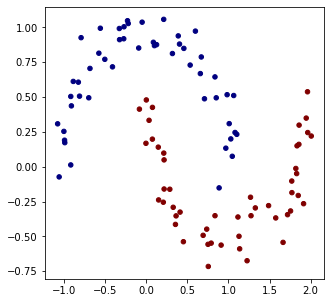

In [3]:
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [4]:
# converts the X matrix into a list of Value objects
inputs = [[Value(i) for i in elem] for elem in X]

### Multi layer perceptron

In [5]:
class PotNet(MLP):
    def __init__(self):
        layers = [
            Layer(nin=2, nout=16, bias=True, activation="relu"),
            Layer(nin=16, nout=16, bias=True, activation="relu"),
            Layer(nin=16, nout=1, bias=True, activation="linear")
        ]
        super().__init__(layers=layers)

model = PotNet()
y_pred = model(inputs[0])
print(y_pred)

Value(data=0.442735, grad=0.000000)


### Full batch gradient descent with BCE loss
Binary Cross Entropy between the target and the input probabilities:
$$l(x,y) = y_i\cdot log x_i + (1-y_i)\cdot log(1-x_i)$$

Note that the targets $y$ should be numbers between 0 and 1


In [6]:
def accuracy_val(y_pred, y_true):
    y_pred = np.array(y_pred).round()
    correct_results = np.sum(y_pred == y_true)
    acc = correct_results/y_true.shape[0]
    acc = np.round(acc * 100)
    return acc

In [7]:
epochs = 200
lr = 0.001
for epoch in range(epochs):
    y_pred = []
    losses = []
    s = time.monotonic()
    for i in range(len(inputs)):
        output = model(inputs[i]).sigmoid()
        y_pred.append(output.data)
        neg_output = Value(1)-output
        target = Value(y[i])
        bce_loss = -(target * output.log() + (Value(1)-target)*neg_output.log())
        losses.append(bce_loss.data)
        bce_loss.backward()
        for p in model.parameters():
            p.data += -lr * p.grad 
        model.zero_grad()
    e = time.monotonic()
    t = e - s
    acc = accuracy_val(y_pred=y_pred, y_true=y)
    loss_epoch = sum(losses) / len(losses)
    if epoch % 10 == 0 or epoch==(epochs-1):
        print(f"epoch: {epoch} |", f"loss: {loss_epoch:.2f} |", f"accuracy: {acc} |", f"time: {t:.2f} sec.")

epoch: 0 | loss: 0.68 | accuracy: 62.0 | time: 0.24 sec.
epoch: 10 | loss: 0.45 | accuracy: 81.0 | time: 0.03 sec.
epoch: 20 | loss: 0.36 | accuracy: 84.0 | time: 0.03 sec.
epoch: 30 | loss: 0.32 | accuracy: 85.0 | time: 0.03 sec.
epoch: 40 | loss: 0.29 | accuracy: 88.0 | time: 0.04 sec.
epoch: 50 | loss: 0.27 | accuracy: 89.0 | time: 0.03 sec.
epoch: 60 | loss: 0.26 | accuracy: 89.0 | time: 0.04 sec.
epoch: 70 | loss: 0.25 | accuracy: 89.0 | time: 0.03 sec.
epoch: 80 | loss: 0.24 | accuracy: 89.0 | time: 0.04 sec.
epoch: 90 | loss: 0.23 | accuracy: 89.0 | time: 0.03 sec.
epoch: 100 | loss: 0.22 | accuracy: 89.0 | time: 0.04 sec.
epoch: 110 | loss: 0.21 | accuracy: 89.0 | time: 0.03 sec.
epoch: 120 | loss: 0.21 | accuracy: 90.0 | time: 0.04 sec.
epoch: 130 | loss: 0.20 | accuracy: 90.0 | time: 0.03 sec.
epoch: 140 | loss: 0.19 | accuracy: 89.0 | time: 0.03 sec.
epoch: 150 | loss: 0.19 | accuracy: 90.0 | time: 0.03 sec.
epoch: 160 | loss: 0.18 | accuracy: 90.0 | time: 0.04 sec.
epoch: 1

### Result

(-1.7153878510921254, 2.0346121489078746)

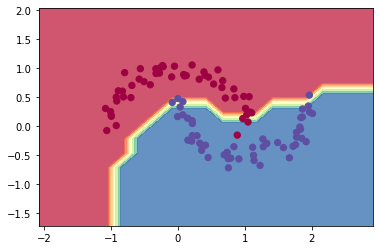

In [8]:
# visualize decision boundary
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())